start
220160 [ 0.00000000e+00  0.00000000e+00 -3.05185095e-05 ...  0.00000000e+00
  0.00000000e+00 -3.05185095e-05]


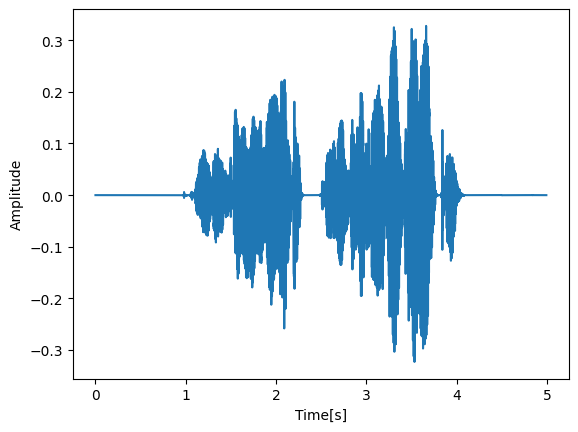

In [12]:
## p100
import pyaudio
import numpy as np
#np._import_array()
from matplotlib import pyplot as plt
import soundfile as sf
import librosa


def get_mic_index(pa):
    """マイクチャンネルを取得する関数"""
    
    # マイクチャンネル一覧をリストに追加する
    mic_list = []
    
    # 音声デバイス一覧を表示する
    for i in range(pa.get_device_count()):
        device_info = pa.get_device_info_by_index(i)
        ## print(f'{device_info}' + '\n')
        num_of_input_ch = device_info['maxInputChannels']
    
        if num_of_input_ch > 0:
            mic_list.append(device_info['index'])
        return mic_list[0]
        
def record(pa, index, duration):
    """PCのマイクで録音する関数"""

    # 録音条件
    sampling_rate = 44100
    frame_size = 1024

    # ストリームを開く
    stream = pa.open(format=pyaudio.paInt16, channels=1, rate=sampling_rate,
                     input=True, input_device_index=index, frames_per_buffer=frame_size)

    # ループ数の設定
    dt = 1 / sampling_rate
    n = int((duration / dt) / frame_size)
    ## print(n)
    
    # 録音する
    waveform = []
    print('start')
    for i in range(n): # 指定秒数分のデータの取得が完了するまでループ
        frame = stream.read(frame_size) # フレームサイズ分のデータを取得
        waveform.append(frame) # 波形に追加

    # ストリームの終了
    stream.stop_stream()
    stream.close()

    # データをまとめる
    waveform = b"".join(waveform)

    # バイトデータを数値に変換
    byte_to_num = np.frombuffer(waveform, dtype="int16")

    # 最大値を計算
    max_value = float((2 ** 16 / 2) - 1)

    # 波形を正規化
    normalized_waveform = byte_to_num / max_value
    
    return normalized_waveform, sampling_rate

def graph_plot(x, y):
    """波形をグラフにする関数"""

    # グラフの設定
    fig, ax = plt.subplots()
    ax.set_xlabel('Time[s]')
    ax.set_ylabel('Amplitude')

    # データのプロット
    for x_axis, y_axis in zip(x, y): # zip を使う方法
        ax.plot(x_axis, y_axis)
    ax.plot(x, y)
    plt.show()
    plt.close()

    return

# PyAudio を準備する
pa = pyaudio.PyAudio()

# マイクチャンネルを自動取得
index = get_mic_index(pa)
## print(index)

# 計測条件を設定して録音関数を実行
duration = 5  ### 録音時間（秒） ###
waveform, sampling_rate = record(pa, index, duration)
print(len(waveform), waveform)

# PyAudio を終了
pa.terminate()

# グラフをプロットする
dt = 1 / sampling_rate
t = np.arange(0, len(waveform) * dt, dt)
graph_plot([t], [waveform]) # リストを使う方法に変更

# wav ファイルに保存する
filename = 'recorded.wav'
sf.write(filename, waveform, sampling_rate)


# ボイスチェンジする
#n_steps = 8
waveform_shifted = librosa.effects.pitch_shift(waveform, sr=sampling_rate, n_steps=8)


# ピッチシフトされた音声を保存する
sf.write('pitch_shifted.wav', waveform_shifted, sampling_rate) # pitch_shifted

# 音声をグラフで比較する
graph_plot([t, t], [waveform, waveform_shifted])

### 音声のピークが右にずれる → 高い音に変化 ###